In [1]:
from brian2 import *
%matplotlib inline

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(20, 10))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

    
def visualise_plasticity(t, rho):
    figure()
    for i in range(len(rho)):
        plot(t, rho[i])

In [4]:
start_scope()
#control parameters
debug = True
simulation_length = 2500
N = 10

F = 1000*Hz

#Variables used in brian code
cpre = 0.1
cpost = 0.1
c = 0.2
dummy = 0.2
Ipre = 0
Ipost = 0
w0 = 0.5
rho = 0.6

#LIF specific constants
V_init = -60
V_rest = -70
V_reset = -70
V_threshold = -50
CM = 0.001
RM = 20.0

tau_lif = 26*ms


sigma = 0
#sigma = 3.3501
#sigma = 0
refrac = 0


#Synapse model specific constants
rho_init = 0.019
ca_initial = 0
ca_delay = 4.61 #ms
Cpre = 0.56175
Cpost = 1.23964
tau_ca = 22.6936
theta_D = 1
theta_P = 1.3
gamma_D = 331.909
gamma_P = 725.085

taurho = 346361*ms
taurho_fast = 10*ms # dummy
taupre = taupost = tau_ca = 22*ms
rho_star = 0.5
D = 4.6098
#v_ext = 30*mV


v = V_init
lif_eqs = '''
dv/dt = (- (v+70) + I_ext) / tau_lif + sigma*xi*tau_lif**-0.5 : 1
I_ext : 1
'''
#P = PoissonGroup(N, rates=F)
# = NeuronGroup(2, eqs, threshold='v>vt', reset='v = vr')
G = NeuronGroup(N, lif_eqs, threshold='v>V_threshold', reset='v = V_reset')
#S = Synapses(G, G, pre='v+=1*mV', connect='i==0 and j==1')

#drho = (-rho*(1-rho)*(0.5-rho) ) / taurho : 1
S = Synapses(G, G,
            model = 
            '''
            w : 1 
            dcpre/dt = -cpre / taupre : 1
            dcpost/dt = -cpost / taupost : 1
            c = cpre + cpost : 1
            dummy = (c>theta_D) : 1
            drho/dt = (-rho*(1-rho)*(0.5-rho) + gamma_P*(1-rho)*(c>theta_P) - gamma_D*rho*(c>theta_D)) / taurho : 1
            ''',
            pre =
            '''
            v_post += rho
            cpre += Cpre
            
            ''',
            post = 
            '''
            cpost += Cpost
            
            ''')
#S.connect('i==0 and j!=0', p=1.0)
S.connect('i!=j', p=0.2)
#tmp = ((np.arange(len(S))+1) * 4).tolist()
#S.delay = tmp*ms

#S.delay = [4, 40, 400, 4000]*ms
S.w = w0


#G.v_ext = np.zeros((N,1), dtype=int32)
G.I_ext = [100] * N
G.I_ext[0] = 100
#P = PoissonInput(G, 'v', N, 100*Hz, weight=0.1)
#S = Synapses(P, G, pre='v+=1*mV', connect='i==j')



print rho
statemon = StateMonitor(G, 'v', record = True)
statemon2 = StateMonitor(S, ['cpre', 'cpost', 'rho','c', 'dummy'], record = True)

spikemon = SpikeMonitor(G)
run(simulation_length*ms,report='stdout', report_period=1*second)
print len(statemon), len(statemon2)

WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable v is present in the namespace but is also an internal variable of neurongroup_2, the internal variable will be used.
WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable rho is present in the namespace but is also an internal variable of synapses_2, the internal variable will be used.
WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable cpre is present in the namespace but is also an internal variable of synapses_2, the internal variable will be used.
WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable cpost is present in the namespace but is also an internal variable of synapses_2, the internal variable will be used.


0.6
Starting simulation for duration 2.5 s
100. us (0%) simulated in 2s, estimated 19h 49m 32s remaining.
0.7466 s (29%) simulated in 3s, estimated 9s remaining.
1.4941 s (59%) simulated in 4s, estimated 3s remaining.
2.2387 s (89%) simulated in 5s, estimated 1s remaining.
2.5 s (100%) simulated in 6s
25000 25000


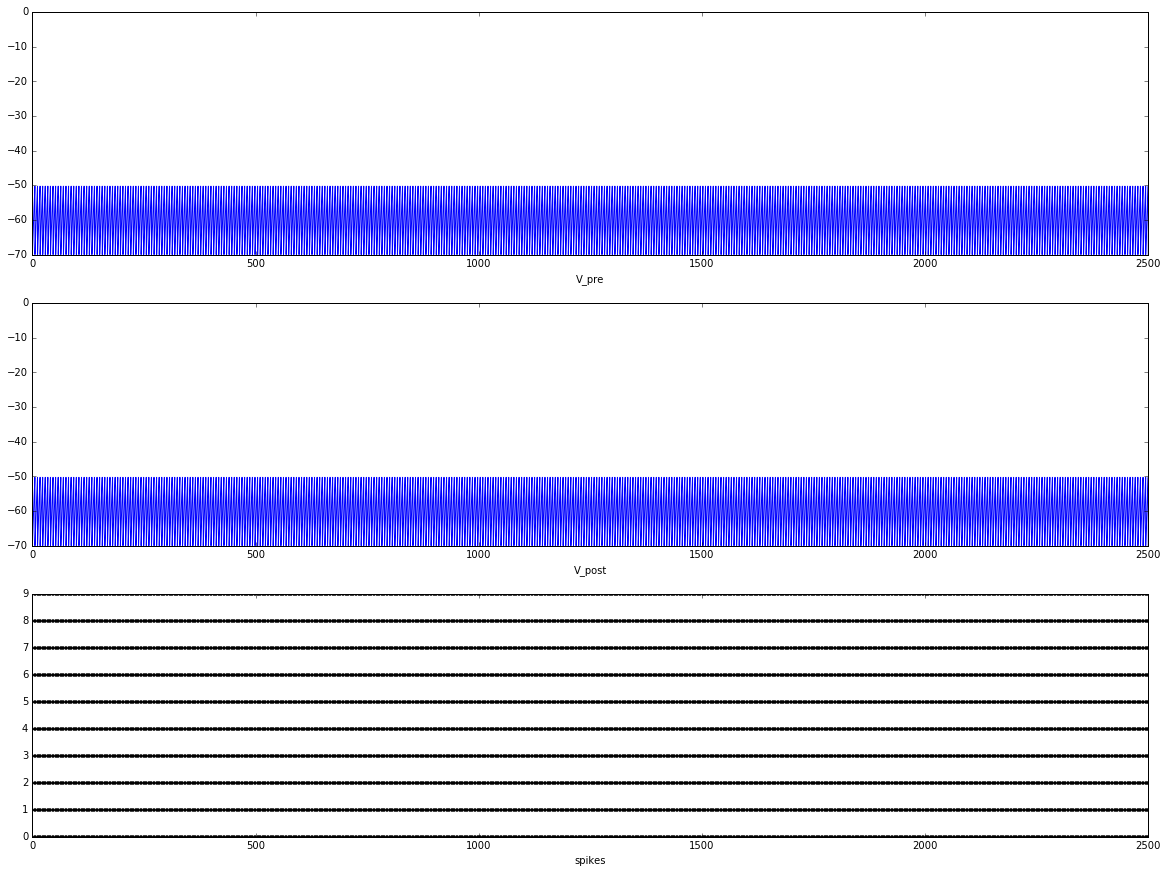

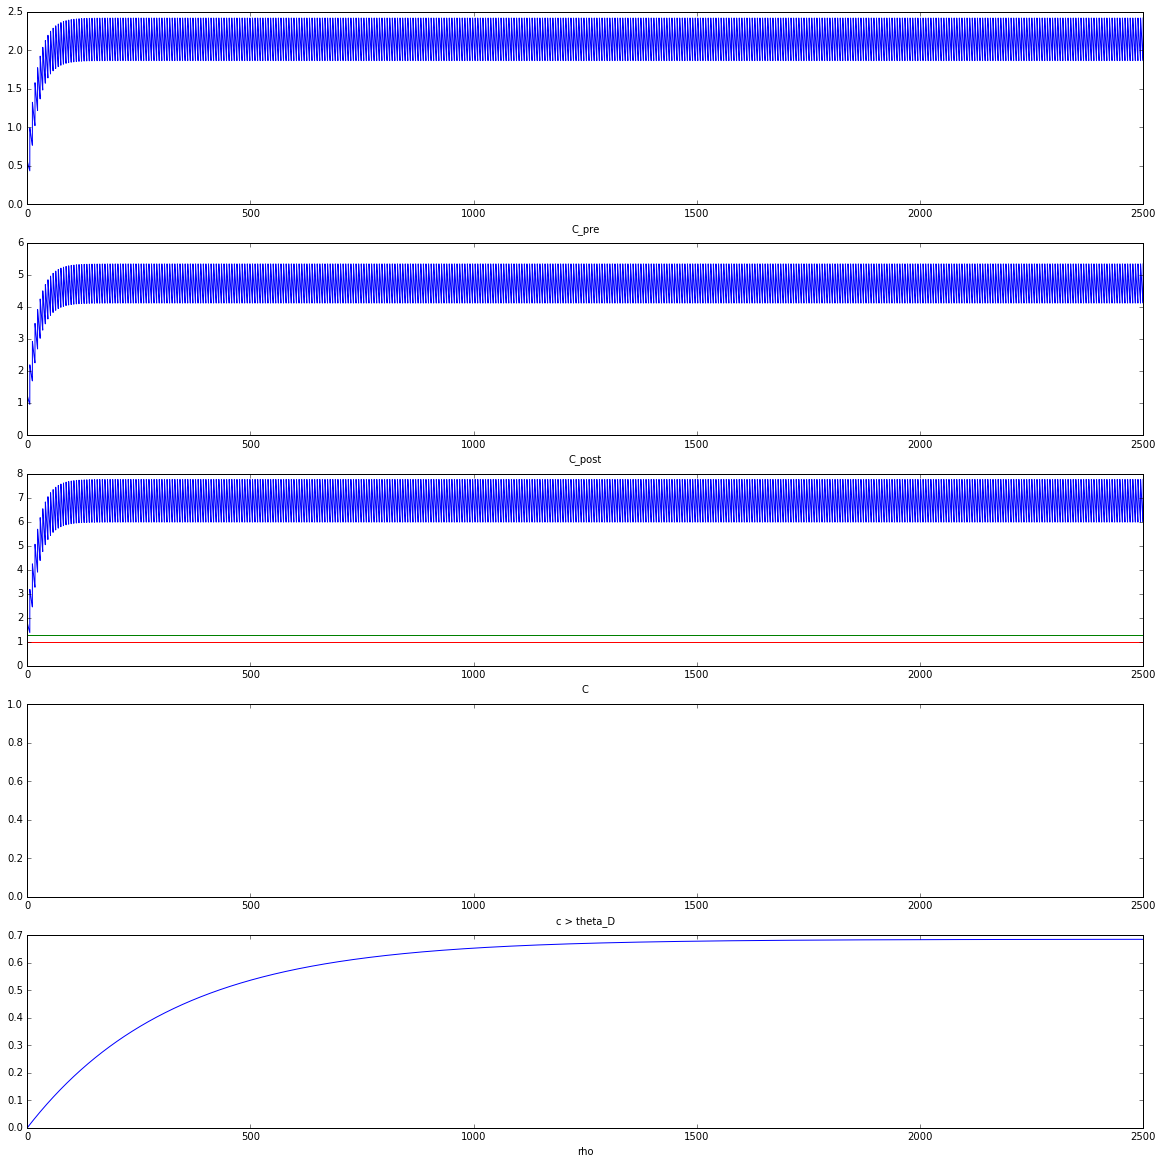

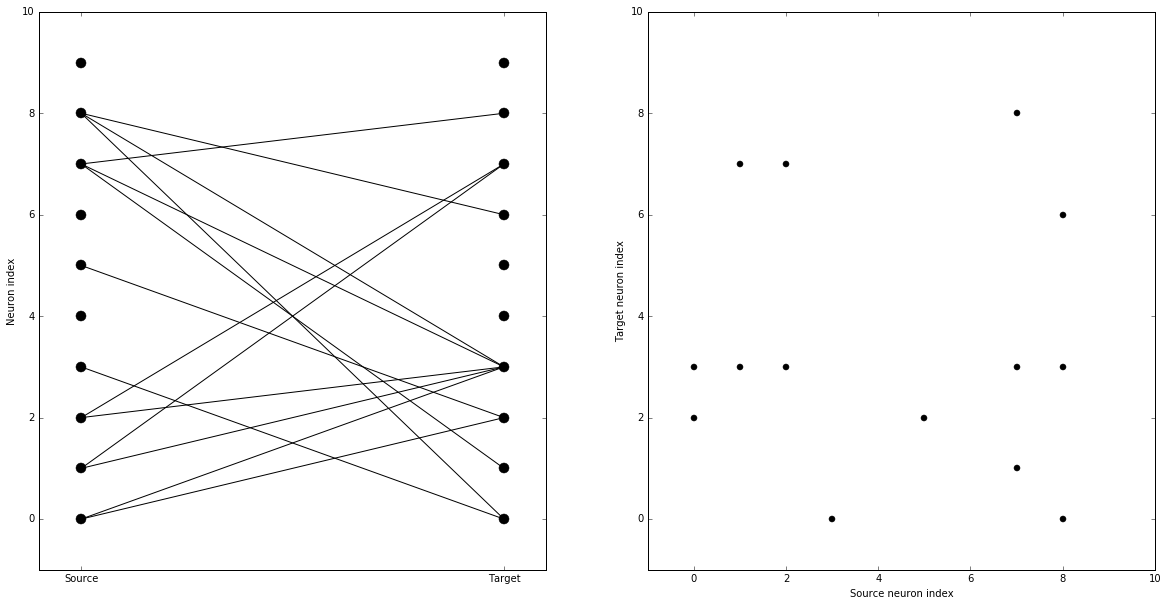

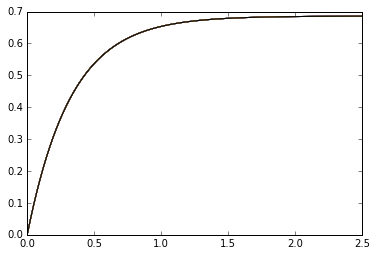

In [5]:
if debug:
    p1 = figure(1, figsize = (20,20))
    subplot(411)
    plot(statemon.t/ms, statemon.v[0])
    xlabel('V_pre')
    subplot(412)
    plot(statemon.t/ms, statemon.v[1])
    xlabel('V_post')
    subplot(413)
    plot(spikemon.t/ms, spikemon.i, '.k')
    xlabel('spikes')
    savefig('a.png')

    p2 = figure(2, figsize = (20,20))
    observe = 0
    subplot(511)
    plot(statemon2.t/ms, statemon2[observe].cpre)
    xlabel('C_pre')
    subplot(512)
    plot(statemon2.t/ms, statemon2[observe].cpost)
    xlabel('C_post')
    subplot(513)
    plot(statemon2.t/ms, statemon2[observe].c)
    plot([0, simulation_length], [theta_P, theta_P])
    plot([0, simulation_length], [theta_D, theta_D])
    xlabel('C')
    subplot(514)
    plot(statemon2.t/ms, statemon2[observe].dummy)
    xlabel('c > theta_D')
    subplot(515)
    plot(statemon2.t/ms, statemon2[observe].rho)
    xlabel('rho')
    savefig('b.png')
    visualise_connectivity(S)
    savefig('c.png')
    
    visualise_plasticity(statemon2.t, statemon2.rho)
    savefig('d.png')

In [ ]:
savefig('a.png')


In [ ]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1
             dapost/dt = -apost/taupost : 1
             ''',
             pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
S.connect(0, 1)
M = StateMonitor(S, ['w', 'apre', 'apost', 'v_post'], record=True)
M2 = StateMonitor(G, 'v', record=True)
run(300*ms)

figure(figsize=(4, 8))
subplot(311)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend(loc='best')
subplot(312)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)')

subplot(313)
plot(M.t/ms, M.v_post[0])

In [ ]:
N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr')
S = Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             connect=True,
             )
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(input)
r_mon = PopulationRateMonitor(input)

run(100*second, report='text')

subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
subplot(313)
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
tight_layout()
show()